# Outline Python script for the Year 3 Physical Chemistry Lab Automated Data Acquisition
### Version 1.1 - Updated 10 October 2020
Nick Brooks

This notebook provides an outline for developing a program that will allow you to investigate the conductivity of simple electronic components. It communicate with an Arduino that is configured to provide as a voltage source, as well as read the potential across the test component and current flowing through it. A full description of the experiment and the way that you communicate with the Arduino is available on Blackboard. 
Before you begin, you will need to install a module that lets Python communicate through a serial connection with other pieces of equipment. You only need to do this once to get everything set up.

Before you start, you need to install a Python module that allows you to work with serial connections to your computer, you only need to do this once and it will stay installed in your Python distribution.

Run the cell below and wait for the module to download and install.

In [1]:
conda install pyserial

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\ProgramData\anaconda3

  added / updated specs:
    - pyserial


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.12.12 |       haa95532_0         127 KB
    certifi-2024.2.2           |  py311haa95532_0         162 KB
    openssl-3.0.13             |       h2bbff1b_0         7.4 MB
    ------------------------------------------------------------
                                           Total:         7.7 MB

The following packages will be UPDATED:

  ca-certificates                     2023.08.22-haa95532_0 --> 2023.12.12-haa95532_0 
  certifi                         2023.7.22-py311haa95532_0 --> 2024.2.2-py311haa95532_0 
  openssl                                 3.0.12-h2bbff1b_0 --> 3.0.13-h2bbff1b_0 




ca-certificates-2023 | 127 KB    |            |   0% 

openssl-3.0.13   



==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 24.1.2

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.1.2




If you receive a 'syntax error' when running to command above, please run the same command in a terminal window. If you are using Windows, you can launch a terminal window by typing CMD into the main Windows search bar (this is usually towards the left of the main toolbar at the bottom of your screen) and running the CMD program. If you are using MacOS or Linux, you can open the 'Terminal' program from your application launcher.

Next you need to point the program that you'll be writing towards the libraries that it will need to run. The libraries that you need are the 'serial' library that contains the commands for serial communicaiton, some parts of serial tools so you can find the name of the port that your instrument is connected to, 'time' for allowing your program to wiat and the standard tools that you have used in the past for data manipulation, curve plotting and fitting.<br>
Run the cell below to import the appropriate libraries.

In [2]:
import serial
import serial.tools.list_ports
import time
#%pylab inline
from scipy.optimize import curve_fit

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

So that you can tell your program where to send and receive information, you need to find the name of the port that you have connected your instrument to. The port is a virtual serial port that runs over the USB connection (effectively the serial commands are send over USB and then decoded in the instrument).<br>
Start by making sure that your Arduino is <b>disconnected</b> from your computer, run the cell below and make a note of the port names that show up (there may be no ports shown at this point). Next <b>connect</b> your instrument to a USB port on your computer, wait for a moment to check that any required drivers are installed (on Windows you may see a message saying that your device is being prepared and then one to say that it is ready for use), and then run the cell below again to get an updated list of the available serial ports. The name of the extra port that shows up with your Arduino connected is the one that you should use in the subsequent code.
Note that the port naming scheme is different depending on your opperating systems:<br>
<b>Windows.</b> If you are using Windows, your Arduino will show up on a port named 'COM' and then a number (e.g. COM7).<br>
<b>MacOS or Linux.</b> If you are using MacOS or Linux, your Arduino port will be named similar to '/dev/cu.usbmodem' and then a number.

In [5]:
ports = serial.tools.list_ports.comports()

for p in ports:
    print(p.device)
print (len(ports), 'ports found')

COM6
COM3
2 ports found


To open the serial connection between your computer and Arduino, you need to specify the parameters that the Arduino uses to communicate. You will need to specify the port name, a baud rate (the number of bits per second) of 9600, and a timeout time of 2 seconds.<br>
You can use the following code outline to open a serial conection that we're going to name 'ser':<br>
```python
ser = serial.Serial('port name', baudrate=x, timeout=x)```

For example (note that you will need to change the port name to match the one found above):

```python
ser = serial.Serial('/dev/cu.usbmodem144301', baudrate=9600, timeout=2)```

In [63]:
ser = serial.Serial('COM6', baudrate = 9600, timeout = 2)

When the serial connection is opened, the Arduino will reset and it will send three lines of information back to the computer. You can read each line into a variable called ```b``` using the code:
```python
b = ser.readline()```

The text is read in as a list of 8-bit characters which you can print out directly, but it may be useful to convert it to a string. You can use the following code to covert the chracter list to a string named ```readstring```:

```python
readstring = b.decode("utf-8")```

Finally, you can print each line as it is read using:

```python
print(readstring)```

You may find it useful to run these commands in a ```for``` loop that repeats 3 times rather than just repeating then 3 times explicitly.

In [64]:
for i in range(3):
    b = ser.readline()
    readstring = b.decode("utf-8")
    print(readstring)
next

Imperial College London - Department of Chemistry

Year 3 Physical Chemistry Lab

Version NB1.0 - 8-9-20



<function next>

Next, you should try to send some commands to the Arduino and then read back the response.<br>
You can send a command using the code: ```ser.write(bytestowrite)```, but remember from above that the information is sent and received as a list of 8-bit characters which is subtally different from a python string. To get a command ready to send, you need to define a string to send, for example using:
```python
writestring = '<S0>'```
Then this string needs to be encoded as a list of 8-bit ASCII characters using:
```python
bytestowrite = writestring.encode()```
After the command has been sent, the Arduino will receive it, process is and respond with one line which you should read as you did in the cell above (but remember there will only be one line now rather than three).

In [11]:
writestring = '<S0>'
bytestowrite = writestring.encode()
ser.write(bytestowrite)

4

In [68]:
# Function for writing command to clean up code 

def write_command(string):
    command = string.encode()
    ser.write(command)
    b = ser.readline()
    readstring = b.decode("utf-8")
    return(readstring)

Now try to set up a loop that sets the applied voltage in small steps between 0 and 5 volts and at each step reads the current running through the LED, and the voltage across it. You will need to store each reading in a list so you can plot them later. You should think about if it is appropriate to insert short delays in the program (for instance to allow the set voltage to stabilise before reading your data), you can do this using the command:
```python
time.sleep(0.1)```
Where the number in brackets is the number of seconds to wait (100 ms in the example above).

In [ ]:
set_voltage_list = np.arange(1,6.1,0.1).round(2)
set_voltage = []


for i in range(len(set_voltage_list)):
    set_voltage.append('<S' + str(set_voltage_list[i]) + '>')
    next

In [ ]:
i = 0
repeats = 50 # Number of repeats, total number o fvoltage samples taken and averaged for each measurement
delay = 0.1 # Delay in the program to allow the set voltage to stabilise before reading your data

voltages = [] # List for set voltages
voltage1 = [] # List for the applied voltages across the circuit
voltage2 = [] # List for the read voltages across LED
current = [] # List for the read current 
        
while i<5.1:    # This can also be a for loop, looping through a created list of set voltages (shown above) 

    j = 0 
    current_list = [] # Clearing current list 
    writestring = '<S' + str(i) + '>' # Round this?
    voltages.append(float(write_command(writestring)[2:-2])) # Returns the actual voltage set (slightly different to input)
    time.sleep(delay) # Waiting for the set voltage to stabilise before reading data
    
    voltage1.append(float(write_command('<V1>')[3:-2])) # Float to rid of V1 and \r\n
    voltage2.append(float(write_command('<V2>')[3:-2]))
    
    # So far we have set the voltage (read back the actual set voltage into voltages)
    # Then had a delay, and read the applied voltage into voltage1 and the voltage across the LED
        
    while j < repeats:
        current_list.append(float(write_command('<I1>')[3:-3])) # Repeats 50 times and adds all currents to a list
        j += 1
    
    current.append(np.mean(current_list)) # Gets the mean of the currents taken and adds one current measurement to the list
    i += 0.1 # Increase set voltage by 0.1V increment
    time.sleep(delay) # Break before next iteration
    
df_blue = pd.DataFrame(data = zip(voltages, voltage1, voltage2, current),
                      columns = ['Set Voltage (V)', 'Applied vol. across circuit (V)', 'Vol. across LED (V)', 'Current (A)'])
df_blue = df_blue[:-1]
df_blue.to_csv('Blue_50_0.1.csv', index = False)

Plot out your data and think about how you could extend the experiment, for example, can you measure multiple LEDs and compare their response, how does the response of an LED compare to a standard resistor?

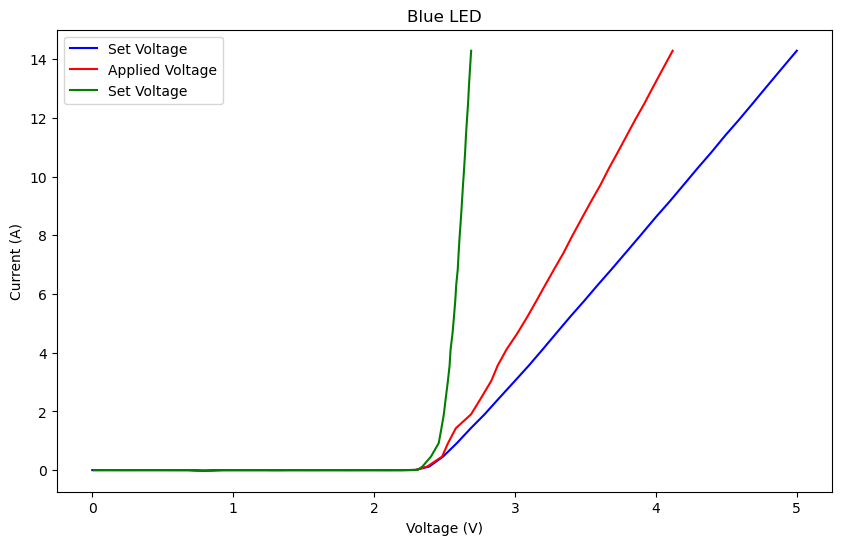

In [23]:
plt.figure(figsize = (10,6))

plt.plot(test_df['Set Voltage (V)'][:-1], test_df['Current (A)'][:-1], color = 'blue', label = 'Set Voltage')
plt.plot(test_df['Applied vol. across circuit (V)'][:-1], test_df['Current (A)'][:-1], color = 'red', label = 'Applied Voltage')
plt.plot(test_df['Vol. across LED (V)'][:-1], test_df['Current (A)'][:-1], color = 'green', label = 'Set Voltage')

legend = plt.legend(loc= 'upper left')
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')
plt.title('Blue LED')
plt.show()

In [65]:
# This is identical code to before, except the while loop has been changed to a for loop because we have been analysing the 
# effect of changing time delay and number of repeats on accuracy (std) of our measurements - hence the voltage has been kept the same

i = 0 
 


voltages = [] # List for set voltages I think
voltage1 = [] # List for the applied voltages
voltage2 = [] # List for the read voltages 
current = [] # List for the read current 
    
repeats = 100 # Number of repeats, total number o fvoltage samples taken and  averaged for each measurement
delay = 0.3 # Delay in the program to allow the set voltage to stabilise before reading your data

for i in range(50):    
    j = 0 
    current_list = [] # Clearing current list 
    writestring = '<S3.0>' # Round this?
    voltages.append(float(write_command(writestring)[2:-2])) # Returns the actual voltage set, see pdf for more
    time.sleep(delay) # Waiting for the set voltage to stabilise before reading data
    
    voltage1.append(float(write_command('<V1>')[3:-2])) # Float to rid of V1 and \r\n
    voltage2.append(float(write_command('<V2>')[3:-2]))
    
    # So far we have set the voltage (read back the actual set voltage into voltages)
    # Then had a delay, and read the applied voltage into voltage1 and the voltage across the LED
        
    while j < repeats:
        current_list.append(float(write_command('<I1>')[3:-3]))
        j += 1
    
    current_listoflists.append(current_list)
    current.append(np.mean(current_list))
    time.sleep(delay) # Break before next iteration
    next

df_test = pd.DataFrame(data = zip(voltages, voltage1, voltage2, current),
                      columns = ['Set Voltage (V)', 'Applied vol. across circuit (V)', 'Vol. across LED (V)', 'Current (A)'])
df_test

,Set Voltage (V),Applied vol. across circuit (V),Vol. across LED (V),Current (A)
0,3.0,2.835,2.521,3.0207
1,3.0,2.805,2.520,3.0277
2,3.0,2.835,2.527,3.0353
3,3.0,2.825,2.525,3.0347
4,3.0,2.835,2.525,3.0300
5,3.0,2.823,2.527,3.0361
6,3.0,2.835,2.527,3.0313
7,3.0,2.802,2.521,3.0412
8,3.0,2.803,2.527,3.0227
9,3.0,2.835,2.516,3.0235


In [66]:
df_test['Current (A)'].std()

0.006070406300492708

In [67]:
df_test.to_csv('Blue_LED_3V_03_100_repeats.csv')

In [56]:
df_one_delay = pd.read_csv('Blue_LED_2V_0.1_delay')
df_one_delay['Vol. across LED (V)'].std()

0.018962734668882788

In [78]:
df_two_delay = pd.read_csv('Blue_LED_2V_0.2_delay')
df_two_delay['Current (A)'].std()

0.0006651683843898771

When you are finished, you should close the serial connection. Only one program at a time can send information to a particular serial port, so by closing the connection, you free it up so that other programs could communicate with your instrument. Make sure you open the connection again when you want to start working again.<br>
You can close the connection using the following command:
```python
ser.close()```